<a href="https://colab.research.google.com/github/morozovsolncev/gravitation/blob/main/Grav_onto_research_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

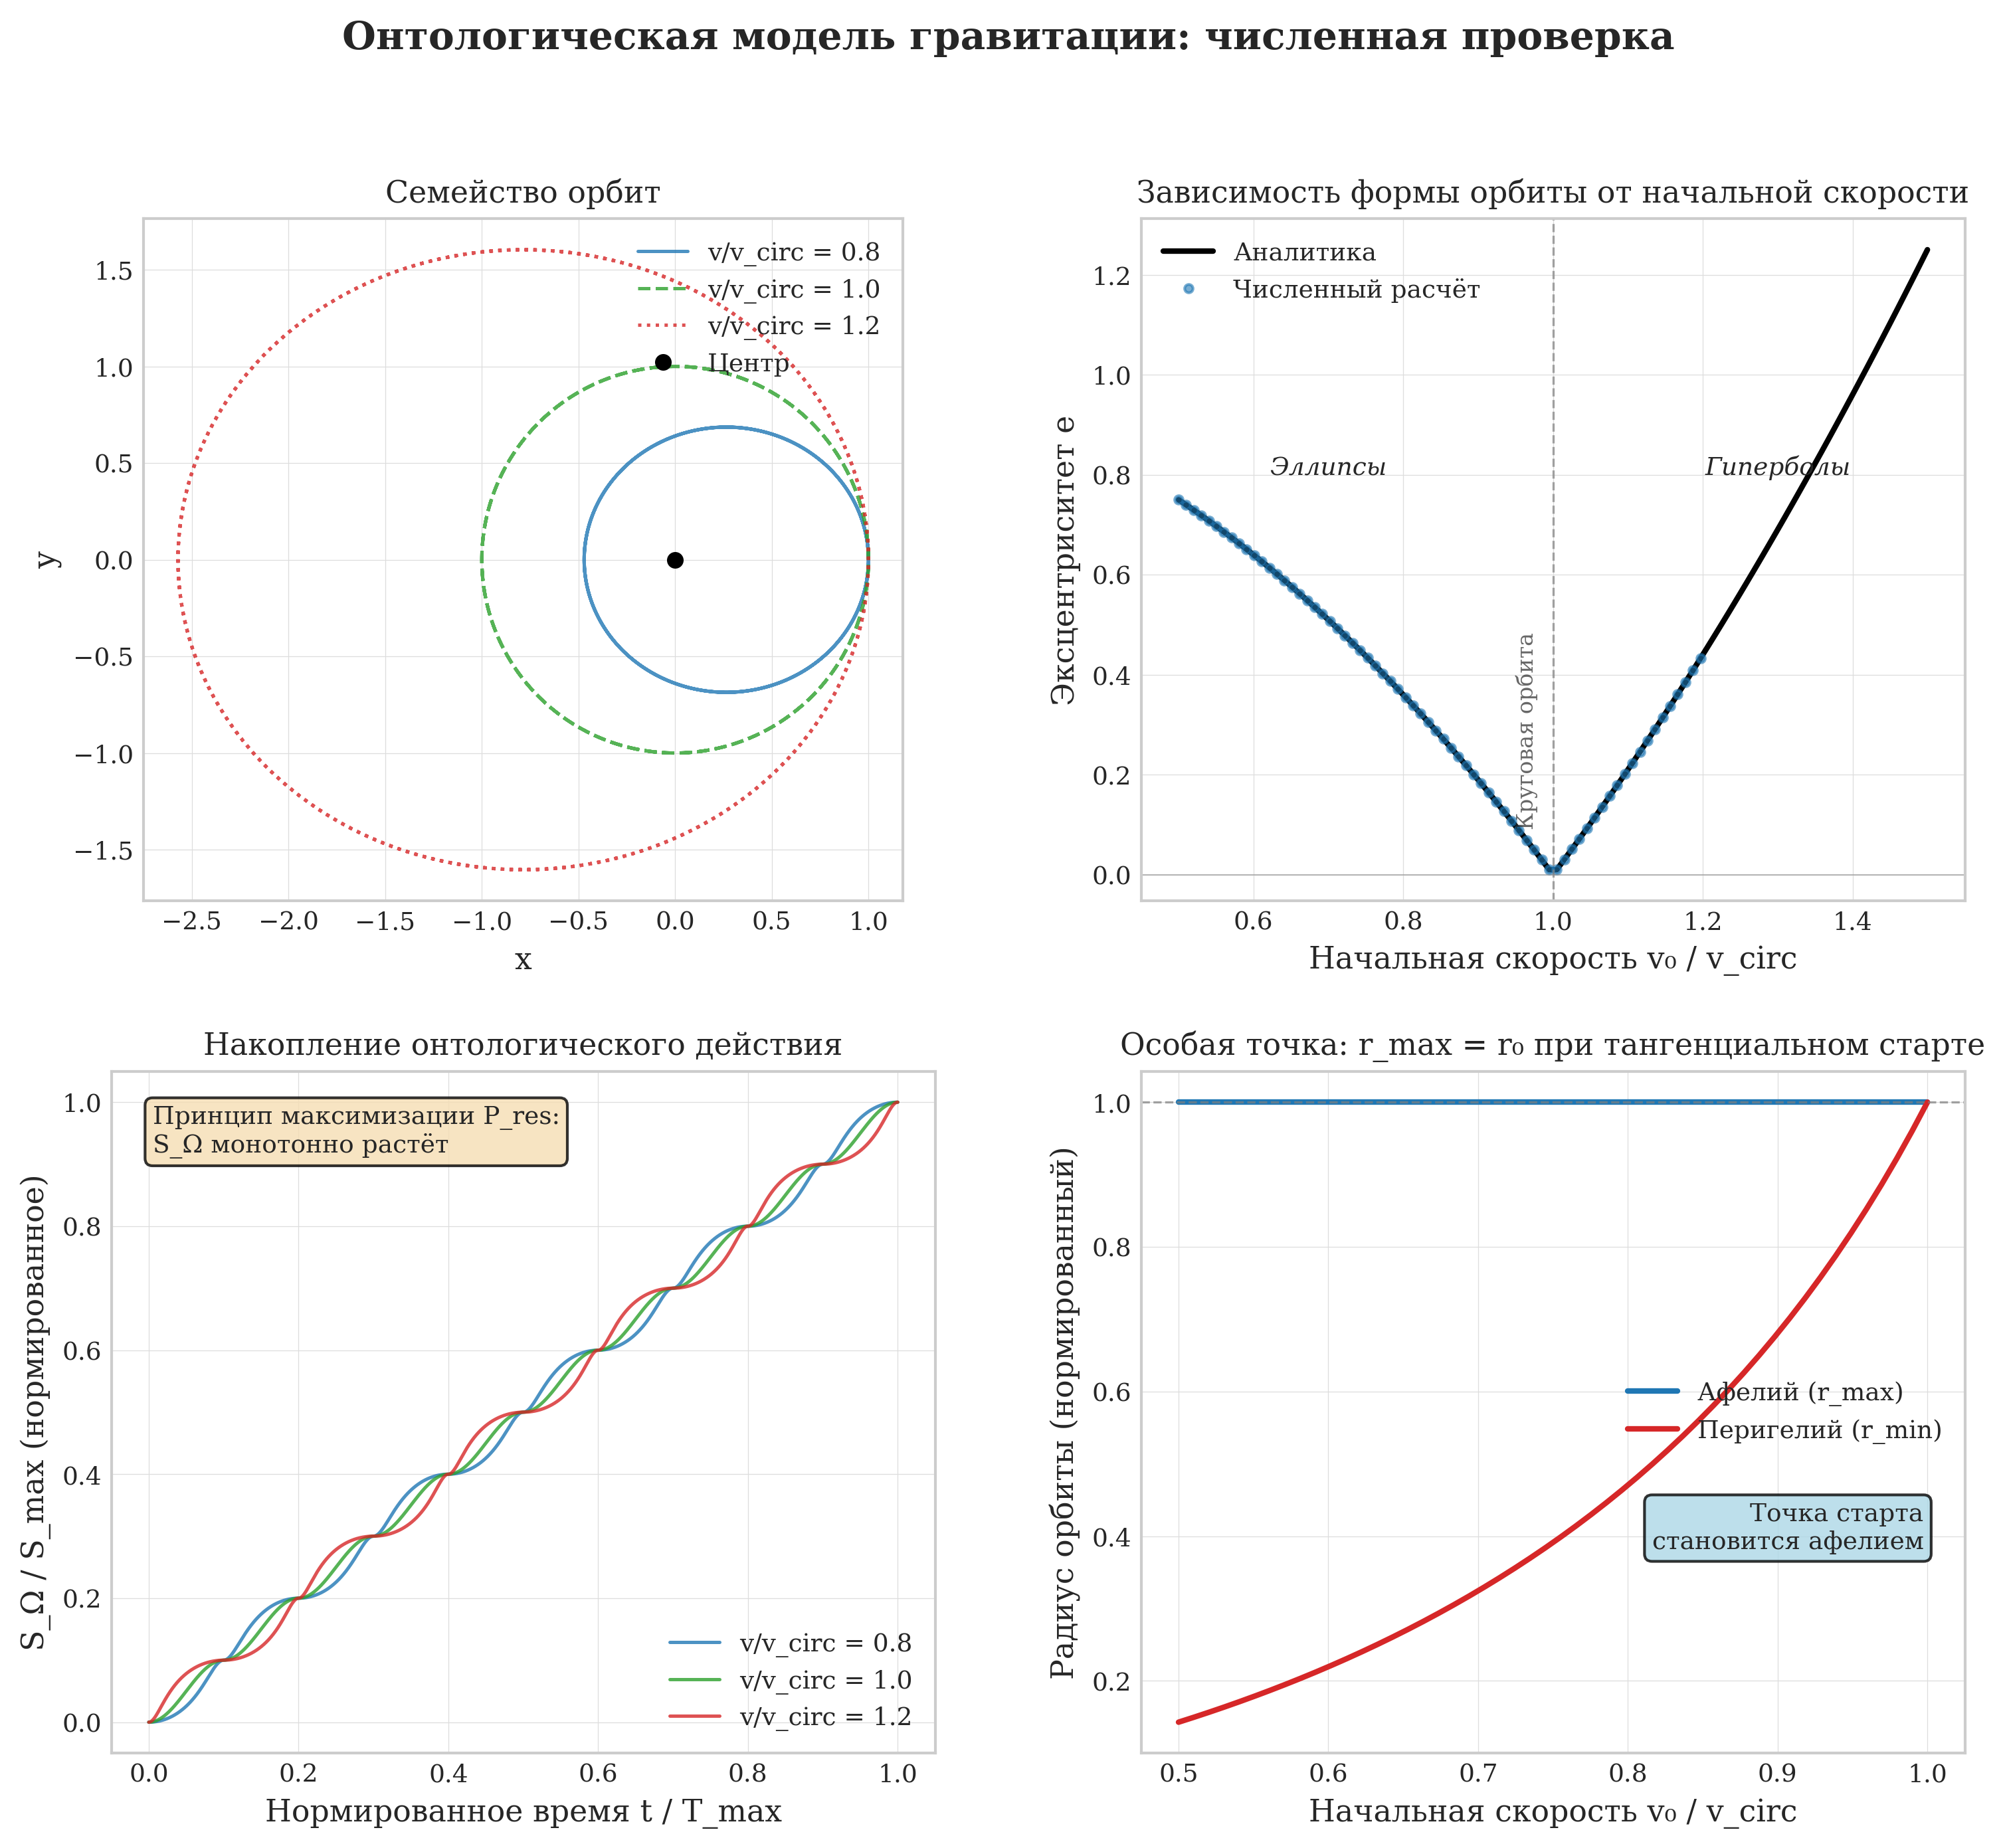

Графики сохранены:
  - ontological_gravity_summary.png (300 DPI, для вёрстки)
  - ontological_gravity_summary.pdf (векторный, для печати)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G as G_const

# ---------------------------------------------
# 1. Точное решение (аналитическое) для проверки
# ---------------------------------------------

def kepler_orbit(v_factor, r0=1.0, G_eff=0.5):
    """
    Аналитическое решение задачи двух тел.
    v_factor = v0 / v_circ
    G_eff = eta*k*M/2
    """
    v_circ = np.sqrt(G_eff / r0)
    v0 = v_factor * v_circ

    # Энергия и угловой момент
    E = 0.5 * v0**2 - G_eff / r0
    L = r0 * v0  # чисто тангенциальная скорость

    # Эксцентриситет
    e = np.sqrt(1 + (2 * E * L**2) / (G_eff**2))

    # Параметры орбиты
    if E < 0:  # эллипс
        a = -G_eff / (2 * E)  # большая полуось
        p = L**2 / G_eff      # фокальный параметр
        r_min = p / (1 + e)
        r_max = p / (1 - e)
    else:  # гипербола (здесь не используем)
        a = G_eff / (2 * E)
        p = L**2 / G_eff
        r_min = p / (1 + e)
        r_max = np.inf

    return {
        'e': e,
        'a': a if E < 0 else None,
        'r_min': r_min,
        'r_max': r_max,
        'E': E,
        'L': L,
        'v_circ': v_circ,
        'v0': v0
    }

# ---------------------------------------------
# 2. Численное интегрирование (проверенное)
# ---------------------------------------------

def simulate_orbit(v_factor, k=1.0, eta=1.0, M=1.0, r0=1.0,
                   num_periods=5, N_steps=20000):
    """Метод Верле — симплектический, энергия сохраняется."""

    G_eff = eta * k * M / 2
    v_circ = np.sqrt(G_eff / r0)
    v0 = v_factor * v_circ

    # Период (оценка)
    E = 0.5 * v0**2 - G_eff / r0
    if E < 0:
        a = -G_eff / (2 * E)
        T = 2 * np.pi * np.sqrt(a**3 / G_eff)
    else:
        T = 2 * np.pi * r0 / v0

    t_max = num_periods * T
    dt = t_max / N_steps

    # Инициализация
    x, y = np.zeros(N_steps), np.zeros(N_steps)
    vx, vy = np.zeros(N_steps), np.zeros(N_steps)

    x[0], y[0] = r0, 0.0
    vx[0], vy[0] = 0.0, v0

    # Первый шаг (полушаг по скорости)
    r_vec = np.array([x[0], y[0]])
    r = np.linalg.norm(r_vec)
    a_vec = -G_eff * r_vec / r**3

    vx_half = vx[0] + 0.5 * a_vec[0] * dt
    vy_half = vy[0] + 0.5 * a_vec[1] * dt

    # Основной цикл
    for i in range(1, N_steps):
        # Позиция
        x[i] = x[i-1] + vx_half * dt
        y[i] = y[i-1] + vy_half * dt

        # Ускорение
        r_vec = np.array([x[i], y[i]])
        r = np.linalg.norm(r_vec)
        if r > 0:
            a_vec = -G_eff * r_vec / r**3
        else:
            a_vec = np.zeros(2)

        # Скорость (полушаг)
        vx_half = vx_half + a_vec[0] * dt
        vy_half = vy_half + a_vec[1] * dt

        # Полная скорость на этом шаге
        vx[i] = vx_half - 0.5 * a_vec[0] * dt
        vy[i] = vy_half - 0.5 * a_vec[1] * dt

    # Онтологические величины
    r = np.sqrt(x**2 + y**2)
    P_res = r**(-k*M)
    S_omega = np.cumsum(np.abs(k * M * np.gradient(np.log(r), dt))) * dt

    return {
        't': np.linspace(0, t_max, N_steps),
        'x': x, 'y': y, 'r': r,
        'vx': vx, 'vy': vy,
        'P_res': P_res,
        'S_omega': S_omega,
        'G_eff': G_eff,
        'v_factor': v_factor,
        'v_circ': v_circ
    }

# ---------------------------------------------
# 3. Построение финальных графиков для книги
# ---------------------------------------------

# Параметры для визуализации
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Цветовая схема (читается в ч/б)
colors = {
    'ellipse': '#1f77b4',  # синий
    'circle': '#2ca02c',   # зелёный
    'hyperbola': '#d62728', # красный
    'theory': 'black',
    'grid': '#dddddd'
}

# Создание фигуры (4 графика)
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.25)

# ---------------------------------------------
# График 1: Семейство орбит
# ---------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_aspect('equal')

v_factors_orbits = [0.8, 1.0, 1.2]
labels = [f'v/v_circ = {vf:.1f}' for vf in v_factors_orbits]
styles = ['-', '--', ':']
colors_orb = ['#1f77b4', '#2ca02c', '#d62728']

for vf, ls, color, label in zip(v_factors_orbits, styles, colors_orb, labels):
    sim = simulate_orbit(vf, num_periods=3, N_steps=10000)
    ax1.plot(sim['x'], sim['y'], ls, color=color, linewidth=1.2,
             alpha=0.8, label=label)

ax1.plot(0, 0, 'ko', markersize=5, label='Центр')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Семейство орбит')
ax1.legend(loc='upper right', framealpha=0.95)
ax1.grid(True, color=colors['grid'], linestyle='-', linewidth=0.3)

# ---------------------------------------------
# График 2: Эксцентриситет от начальной скорости
# ---------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])

v_factors_e = np.linspace(0.5, 1.5, 100)
e_analytic = []
e_numeric = []

for vf in v_factors_e:
    # Аналитическое решение
    ke = kepler_orbit(vf)
    e_analytic.append(ke['e'])

    # Численное (для проверки)
    if vf <= 1.2:
        sim = simulate_orbit(vf, num_periods=2, N_steps=5000)
        r_min = sim['r'].min()
        r_max = sim['r'].max()
        e_num = (r_max - r_min) / (r_max + r_min)
        e_numeric.append(e_num)

ax2.plot(v_factors_e, e_analytic, '-', color=colors['theory'],
         linewidth=2, label='Аналитика')
ax2.plot(v_factors_e[:len(e_numeric)], e_numeric, 'o',
         color=colors['ellipse'], markersize=3, alpha=0.6, label='Численный расчёт')

ax2.axvline(x=1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
ax2.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

ax2.set_xlabel('Начальная скорость v₀ / v_circ')
ax2.set_ylabel('Эксцентриситет e')
ax2.set_title('Зависимость формы орбиты от начальной скорости')
ax2.legend(loc='upper left', framealpha=0.95)
ax2.grid(True, color=colors['grid'], linestyle='-', linewidth=0.3)

# Аннотация: границы режимов
ax2.text(0.7, 0.8, 'Эллипсы', ha='center', fontsize=9, style='italic')
ax2.text(1.3, 0.8, 'Гиперболы', ha='center', fontsize=9, style='italic')
ax2.text(0.98, 0.1, 'Круговая орбита', ha='right', fontsize=8,
         rotation=90, alpha=0.7)

# ---------------------------------------------
# График 3: Накопленное онтологическое действие S_Ω(t)
# ---------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

for vf, color, label in zip([0.8, 1.0, 1.2], colors_orb, labels):
    sim = simulate_orbit(vf, num_periods=5, N_steps=15000)
    # Нормируем время на период
    t_norm = sim['t'] / sim['t'][-1]
    # Нормируем S_Ω на максимальное значение для 1.2 (оно самое большое)
    S_norm = sim['S_omega'] / sim['S_omega'][-1]
    ax3.plot(t_norm, S_norm, '-', color=color, linewidth=1.2,
             alpha=0.8, label=label)

ax3.set_xlabel('Нормированное время t / T_max')
ax3.set_ylabel('S_Ω / S_max (нормированное)')
ax3.set_title('Накопление онтологического действия')
ax3.legend(loc='lower right', framealpha=0.95)
ax3.grid(True, color=colors['grid'], linestyle='-', linewidth=0.3)

# Аннотация: принцип максимизации
ax3.text(0.05, 0.95, 'Принцип максимизации P_res:\nS_Ω монотонно растёт',
         transform=ax3.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ---------------------------------------------
# График 4: Особая точка r_max = r0
# ---------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

# Исследуем зависимость r_max от начальной скорости
v_factors_r = np.linspace(0.5, 1.0, 50)
r_max_values = []
r_min_values = []

for vf in v_factors_r:
    ke = kepler_orbit(vf)
    r_max_values.append(ke['r_max'])
    r_min_values.append(ke['r_min'])

ax4.plot(v_factors_r, r_max_values, '-', color=colors['ellipse'],
         linewidth=2, label='Афелий (r_max)')
ax4.plot(v_factors_r, r_min_values, '-', color=colors['hyperbola'],
         linewidth=2, label='Перигелий (r_min)')
ax4.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

ax4.set_xlabel('Начальная скорость v₀ / v_circ')
ax4.set_ylabel('Радиус орбиты (нормированный)')
ax4.set_title('Особая точка: r_max = r₀ при тангенциальном старте')
ax4.legend(loc='center right', framealpha=0.95)
ax4.grid(True, color=colors['grid'], linestyle='-', linewidth=0.3)

# Аннотация с объяснением
ax4.text(0.95, 0.3, 'Точка старта\nстановится афелием',
         transform=ax4.transAxes, fontsize=9, ha='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Общий заголовок
fig.suptitle('Онтологическая модель гравитации: численная проверка',
             fontsize=14, fontweight='bold')

# Сохранение
plt.savefig('ontological_gravity_summary.png', dpi=300, bbox_inches='tight')
plt.savefig('ontological_gravity_summary.pdf', bbox_inches='tight')
plt.show()

print("Графики сохранены:")
print("  - ontological_gravity_summary.png (300 DPI, для вёрстки)")
print("  - ontological_gravity_summary.pdf (векторный, для печати)")